# ДЗ №1 - обучение модели линейной регресии методом градиентного спуска

Реализовать обучение модели линейной регрессии методом градиентного спуска.<br />

В качестве подводящего упражнения в этом задании предлагается реализовать функции потерь и саму модель линейной регрессии в манере, схожей с построением модулей фреймворка pytorch (см. пояснения в шаблонах кода)

В решении ожидается наличие следующих ключевых составляющих:<br />

#### Текстовое описание в решении:
- формулировка задачи, формулировка признакового описания объектов, формулировка функции ошибки, формулировка меры качества модели;
- исследование исходных данных на предмет скоррелированности признаков; фильтрация признаков; порождение признаков (при необходимости);
- оценка параметров модели линейной регрессии (обучение модели) методом градиентного спуска;
- оценка качества модели на валидационной выборке.

#### Код решения:
(используйте предлагаемые шаблоны)
- формулировка модели линейной регрессии;
- формулировка функции ошибки;
- формулировка метрики (метрик);
- формулировка цикла оптимизации параметров.


#### Визуализация в решении:
- распределение признаков;
- распределение целевой переменной;
- эволюция функции ошибки и выбранных метрик качества по ходу обучения.

#### Выводы (в форме текста!)
- вывод о том, насколько модель подходит для описания данных
- вывод о достаточности или избыточности данных для оценки параметров модели
- вывод о соотношении выразительности модели и ее обобщающей способности (наблюдаются ли явления переобучения или недообучения).

Примечания:<br />
Допустимо порождение признаков (полиномиальных, экспоненциальных, логарифмических, etc.)<br />
Реализация линейной регрессии может быть написана только с использованием библиотеки Numpy. Решения с использованием библиотек автоматического вычисления градиентов не засчитываются.<br />
Из готовых реализаций (напр., из пакета scikit-learn) в этом задании допускается использовать только порождение полиномиальных признаков `PolynomialFeatures`.

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

Данные находятся в следующих файлах:

Признаковое описание объектов обучающей выборки - в файле X_train.npy

Значения целевой переменной на обучающей выборке - в файле y_train.npy

Способ чтения данных из файлов *.npy :

```
import numpy as np
data = np.load('/path/to/filename.npy')
```

In [2]:
# X_data = np.load('X_train.npy')
# Y_data = np.load('y_train.npy')


### Примечание на предмет реализации градиента функции потерь

Нелишним будет вспомнить способ вычисления градиента сложной функции. Здесь функция ошибки (обозначено как $\mathscr{L}$) представлена как сложная функция $\mathscr{L}\left( G\left( \theta \right) \right)$. Для простоты приведена сразу матричная запись.

$$
\nabla_{\theta}{\mathscr{L}} = \nabla_{\theta}{G}\cdot\left(\nabla_{G}{\mathscr{L}}\right)
$$

В качестве шпаргалки можно подсмотреть правила матричного дифференцирования <a href="https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf">здесь</a>

Например, в случае функции потерь MSE это может выглядеть следующим образом:

$$
\nabla_{\theta}{\mathscr{L}} = X^T\cdot2\left(X\theta - Y\right)
$$


При этом логически имеет смысл реализовать компоненту градиента, относящуюся собственно к функции потерь $\nabla_{G}{\mathscr{L}}$ - в коде класса функции потерь, а компоненту, относящуюся к модели $\nabla_{\theta}{G}$ - в коде модели.

Именно поэтому классы `loss` и `linear_regression` в предложенном шаблоне реализованы наследующими `Differentiable` - для общности восприятия этих модулей как дифференцируемых по своим аргументам.

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import time

In [4]:
X_tr = np.load('./X_train.npy')
Y_tr = np.load('./y_train.npy')
X_data = pd.DataFrame(X_tr, columns=['Feature_1', 'Feature_2', 'Feature_3','Feature_4'])
Y_tr.shape

(10000, 1)

## Посмотрим попарную зависимость признаков

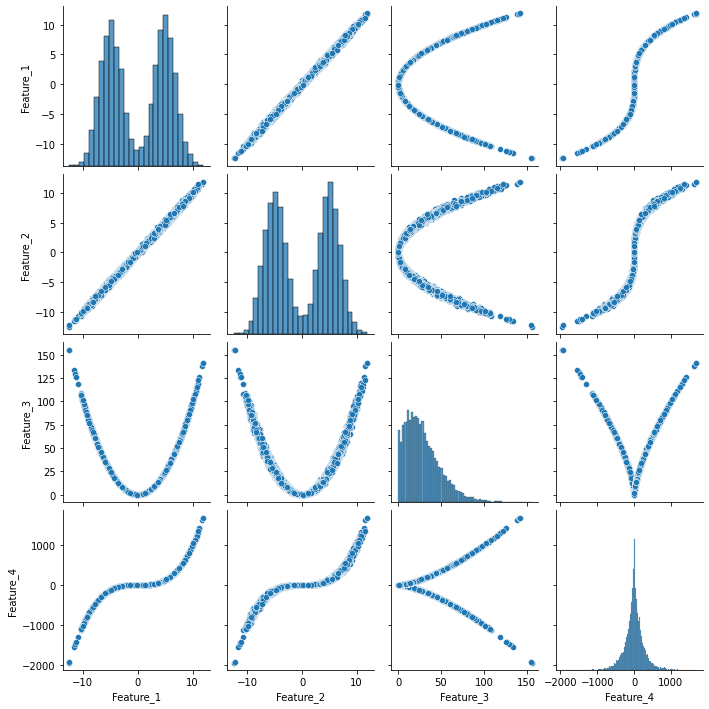

In [5]:
sns.pairplot(X_data)

Как видно из графиков признаки 1 и 2 являются линейно зависимыми
Для возможности расчета оценочного параметра необходимо будет убрать один из этих признаков

In [6]:
X_tr_main = X_tr[:,1:]
Y_tr_main = Y_tr
X_tr_main.shape

(10000, 3)

In [7]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

In [8]:
class loss(Differentiable):
    def __init__(self):
        super(loss, self).__init__()
    
    def forward(self, y_pred, y_true):
        # Этот метод реализует вычисление значения функции потерь
        # Подсказка: метод должен возвращать единственный скаляр - значение функции потерь
        loss_value = 0.0
        
        N = y_pred.shape[0] 
        loss_value = ((y_pred - y_true).T @ (y_pred - y_true))/N # Mean Square Error
        return loss_value
    
    
    def backward(self, y_pred, y_true):
        # Этот метод реализует вычисление градиента функции потерь по аргументу y_pred
        # Подсказка: метод должен возвращать вектор градиента функции потерь
        #           размерностью, совпадающей с размерностью аргумента y_pred
        
        partial_grad = np.zeros_like(y_pred-y_true)

        N = y_pred.shape[0]
        partial_grad = 2*(y_pred - y_true)/N
        
        return partial_grad

In [9]:
def create_mini_batches(X, y, batch_size):
    mini_batches = []

    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    for i in range(n_minibatches):
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))
    return mini_batches


# Напишем функцию разделения данных на тестовую и обучающую
def train_test(X, y, train_num):
    data = np.hstack((X, y))
    np.random.shuffle(data)
    
    train_batch = data[:train_num]
    X_train = train_batch[:,:-1]
    Y_train = train_batch[:,-1].reshape((-1, 1))
    test_batch = data[train_num+1:]
    X_test = test_batch[:,:-1]
    Y_test = test_batch[:,-1].reshape((-1, 1))
    
    return X_train, Y_train, X_test, Y_test


In [10]:
class linear_regression(Differentiable):
    def __init__(self):
        super(linear_regression, self).__init__()
        self.theta = None
    
    def __call__(self, X):
        # этот метод предназначен для вычисления значения целевой переменной
        return self.forward(X)
    
    def backward(self, X):
        # Этот метод реализует вычисление компоненты градиента функции потерь
        
        partial_grad = 0.0
        partial_grad = X.T
        return partial_grad
    
    def forward(self, X):
        # этот метод предназначен для применения модели к данным
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"

        X = np.hstack((X, np.ones((X.shape[0], 1))))

        y_pred = X @ self.theta # потому что Y имеет размерность (10000, 1)
        
        
        return X, y_pred

In [11]:
def Mini_Batch_Gradient_Descent(X, y, model, loss_fn, epochs=100, alpha=0.00001, batch_size=50):
    loss_history = []
    pbar = tqdm(total=epochs)

    model.theta = np.random.normal(0, 1, (X.shape[1] + 1, 1)) # create array of weights with size(n+1, 1),where n is the number of features
    for epoch in range(epochs):       
        batches = create_mini_batches(X, y, batch_size)
        for batch in batches[:-1]:
#             , dtype=object
            X_1 = batch[0]
            y_true = batch[1]

            X_1, y_predict = model.forward(X_1) 
            grad = model.backward(X_1) @ loss_fn.backward(y_predict, y_true)
            model.theta -= alpha*grad
            loss_value = loss_fn.forward(y_predict, y_true)[0][0] 
            loss_history.append(loss_value)

            
        
        
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value})
    pbar.close()
    return np.array(loss_history)

In [12]:
X_train, Y_train, X_test, Y_test = train_test(X_tr_main, Y_tr_main, 8000)


In [16]:
Xtr = X_train
ytr = Y_train
obj_fn = loss()
lr_model = linear_regression()
start = time.time()
%timeit
loss_history = Mini_Batch_Gradient_Descent(Xtr, ytr, lr_model, obj_fn, epochs=1000)
end = time.time()
print(end - start)

100%|██████████| 1000/1000 [00:18<00:00, 53.25it/s, loss=0.467]

18.801778554916382


(0.0, 20.0)

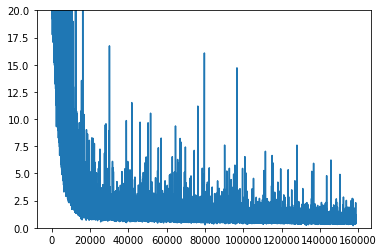

In [17]:
plt.plot(loss_history)
plt.ylim(0,20)

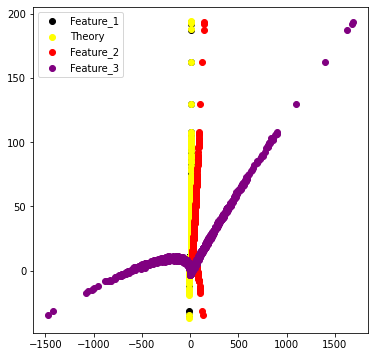

0.7053365208860587

In [19]:
X1, Y_pred = lr_model.forward(X_test)
plt.figure(figsize=(6,6))
plt.scatter(X_test[:,0], Y_test, color='black', label='Feature_1')
plt.scatter(X_test[:,0], Y_pred, color='yellow', label='Theory')
plt.scatter(X_test[:,1], Y_test, color='red', label='Feature_2')
plt.scatter(X_test[:,2], Y_test, color='purple',label='Feature_3')
plt.legend()


plt.show()

error = np.sum((Y_pred - Y_test).T @ (Y_pred - Y_test)/Y_test.shape[0])
error

 __Как можно убедиться из графика, Линейная регрессия аппроксимирует хорошо лишь по одному из признаку__